# Forecasting properly again

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

Just doing forecasting first. Need to add noise so that the forecasting is as accurate as possible.

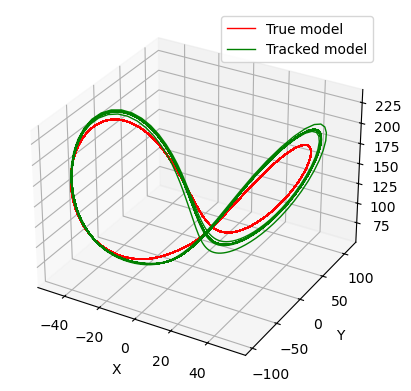

In [7]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])

## Finding Wout matrix using ridge regression
f = f[:, -10000:] 
R = R[:, -10000:]
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  


### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest)             
ypid = np.zeros(ntest)
zpid = np.zeros(ntest)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()



Now adding Gaussian noise

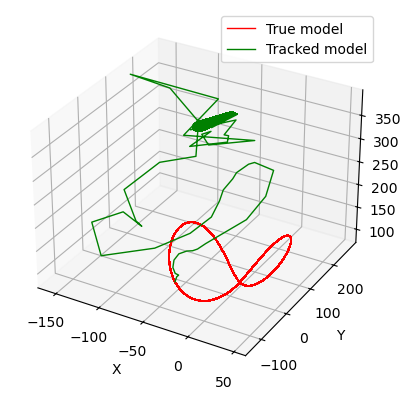

In [11]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])


## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]

## Adding gaussian noise to the data
f = f + np.random.normal(0, 0.1, f.shape)

## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest)             
ypid = np.zeros(ntest)
zpid = np.zeros(ntest)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


Clearly, just adding noise to the final data failed miserably. Need to add noise in a different manner. Or try with lower variance in the noise term.

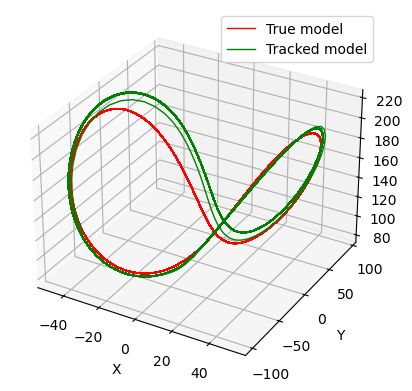

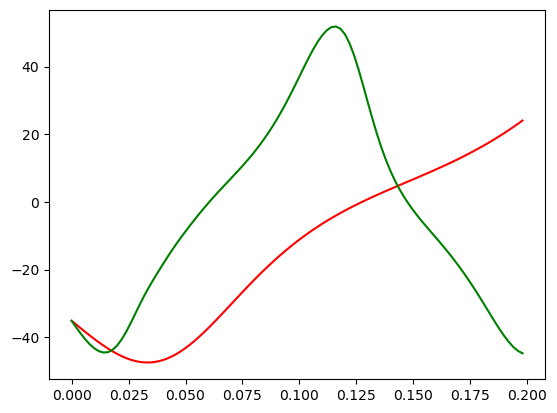

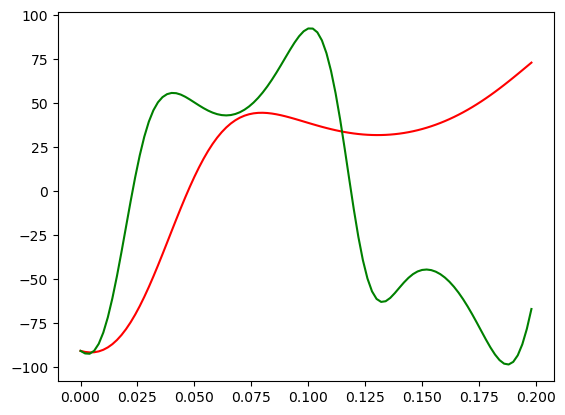

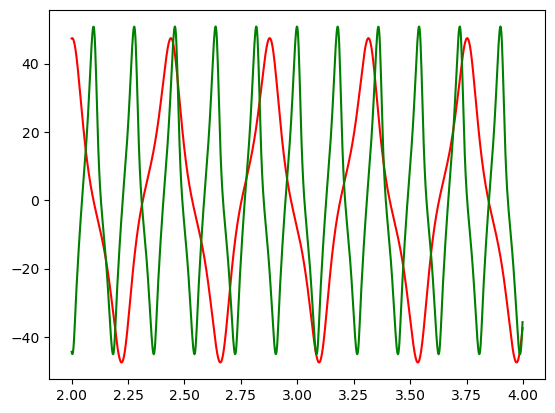

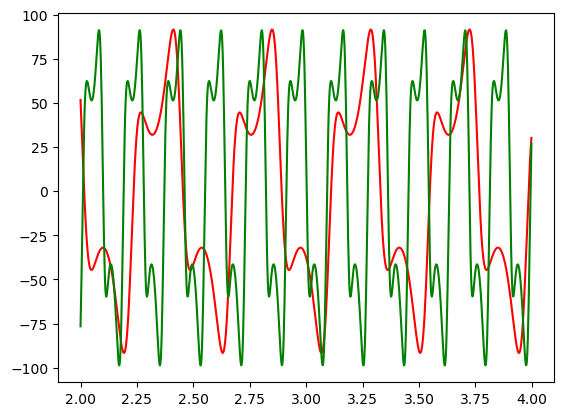

In [19]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])


## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]

## Adding gaussian noise to the data
f = f + np.random.normal(0, 0.005, f.shape)

## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest)             
ypid = np.zeros(ntest)
zpid = np.zeros(ntest)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plottimerange = np.arange(1000, 2000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

Without A

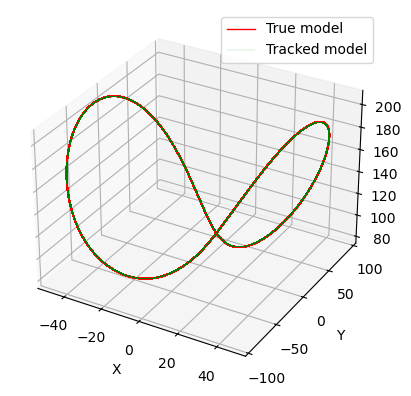

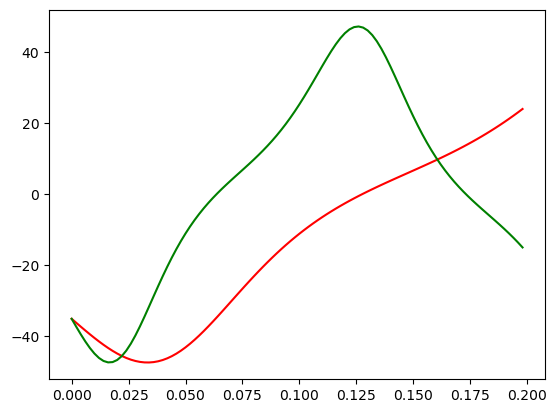

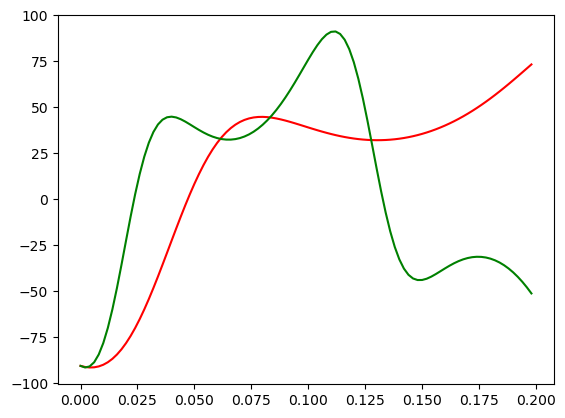

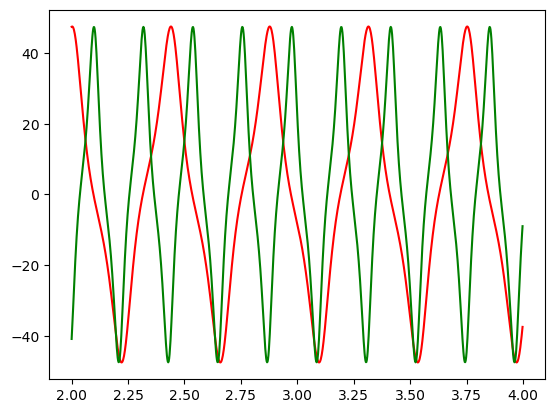

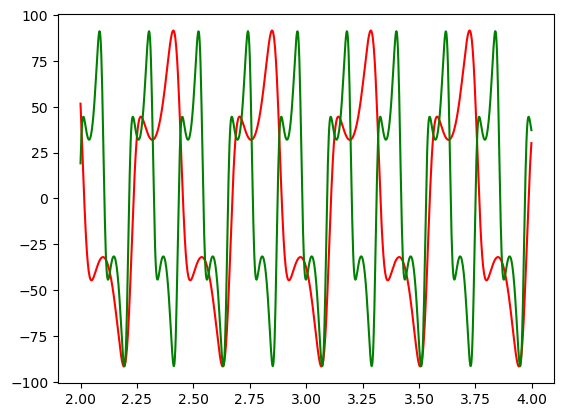

In [16]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)
rorig = rpid

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])




## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]

## Adding gaussian noise to the data
f = f + np.random.normal(0, 0.005, f.shape)

## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  


# x, y, z = -7.45, -3.03, 0.01
# rpid = rorig
# xpredtrain = np.zeros(ntraining)
# ypredtrain = np.zeros(ntraining)
# zpredtrain = np.zeros(ntraining)

# for t in range(ntraining):

#     xpredtrain[t], ypredtrain[t], zpredtrain[t] = Wout_pid.dot(R[:, t])


# plottimerange = np.arange(0, 100)

# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], xpredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], ypredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


# plottimerange = np.arange(1000, 2000)

# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], xpredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


# plt.figure()
# plt.plot(trainingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
# plt.plot(trainingtimes[plottimerange], ypredtrain[plottimerange],  'g', label = 'Tracked model')
# plt.show()


### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest)             
ypid = np.zeros(ntest)
zpid = np.zeros(ntest)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z

xxtrack = np.zeros(ntest)             
yytrack = np.zeros(ntest)
zztrack = np.zeros(ntest)

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    rpid = np.tanh(Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack





plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plottimerange = np.arange(1000, 2000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Tracked model')
plt.show()

Why is the period doubling?

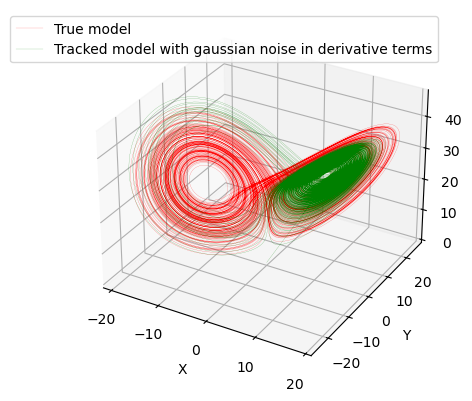

Average of distances calculated at each instant: 18.01141736173197
Average of minimum distances: 1.2590766819615136


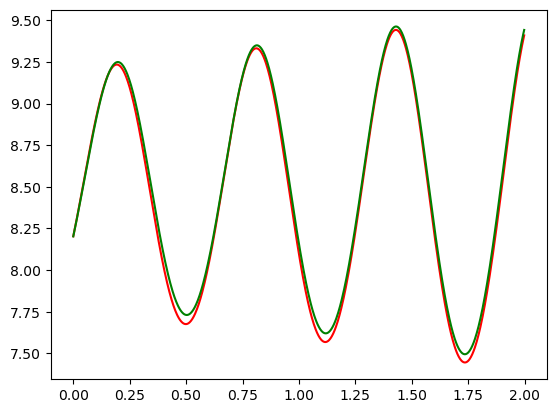

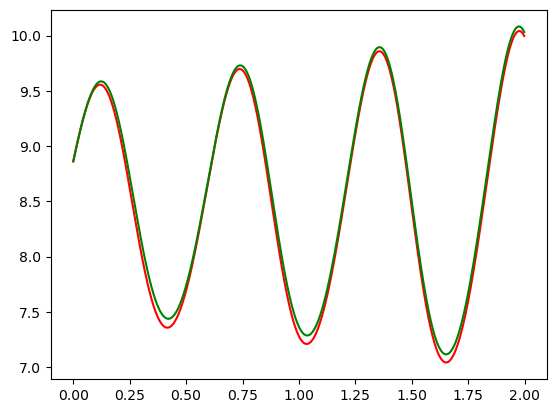

In [33]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])          ############### This one line makes all the difference?
    ##### Why? #####

    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system

    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with gaussian noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot( testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot( testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()

Slight reordering in the training code makes all the difference. The R index should correspond to the correct f index

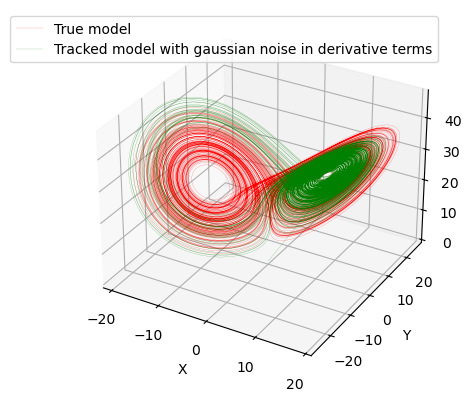

Average of distances calculated at each instant: 17.706763304087314
Average of minimum distances: 1.9684646884112007


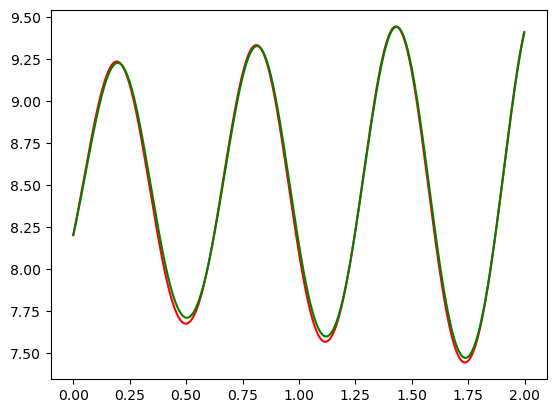

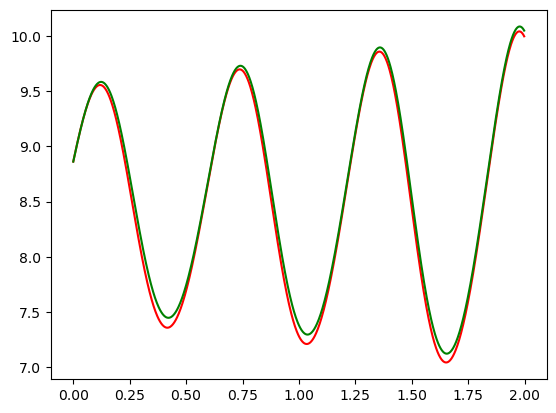

In [34]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    R[:, t] = rpid
    f[:, t] = np.array([x, y, z])          ############### This one line makes all the difference?
    ##### Why? #####

    #f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system

    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with gaussian noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot( testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot( testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()

# Working forecasting model

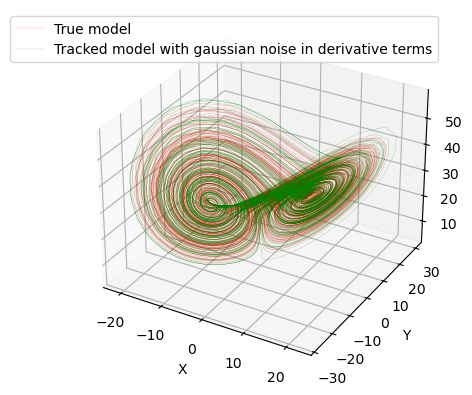

Average of distances calculated at each instant: 18.9551292987991
Average of minimum distances: 0.45438070280333687


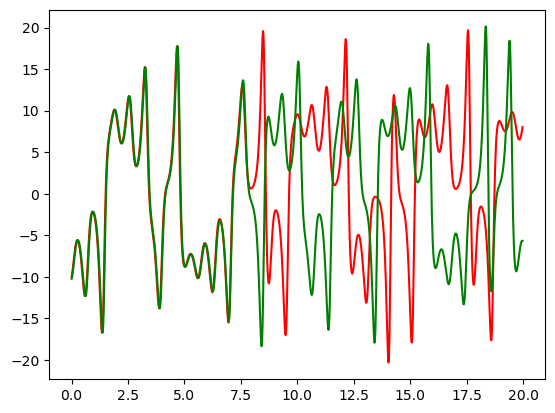

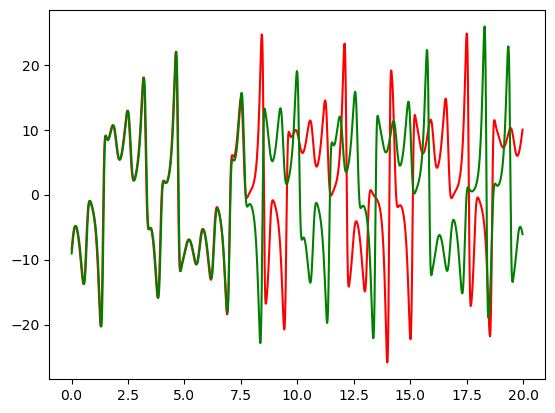

In [15]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 300                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.02
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)

    xpid[t + 1] = xtrack
    ypid[t + 1] = ytrack
    zpid[t + 1] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with gaussian noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()

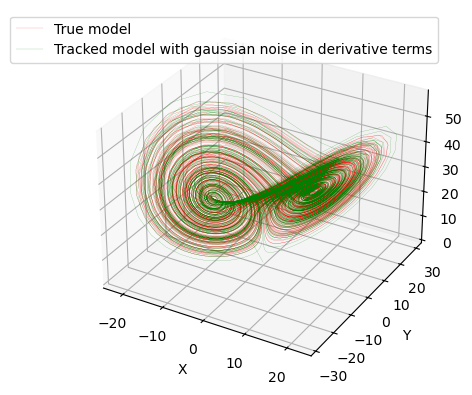

Average of distances calculated at each instant: 18.526425228661488
Average of minimum distances: 0.4006984911144004


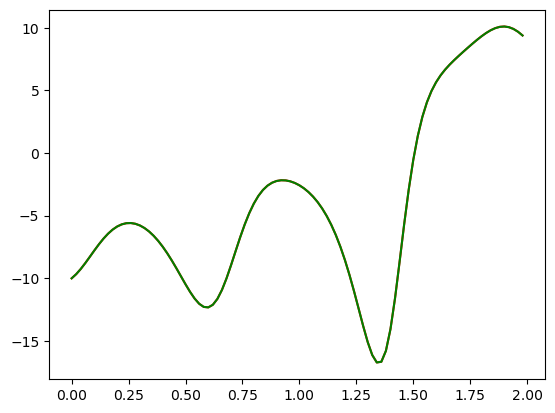

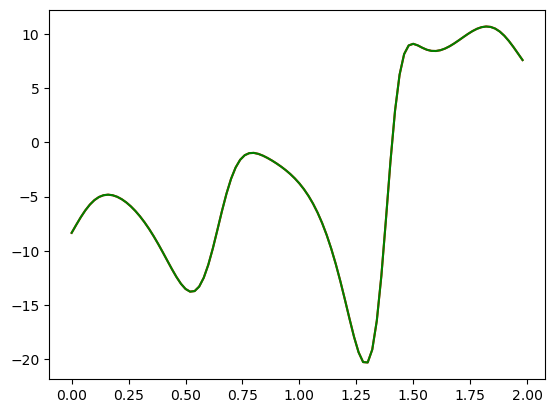

In [28]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 300                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.02
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    
    

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with gaussian noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], xpid[:100],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:100], ypure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], ypid[:100],  'g', label = 'Tracked model')
plt.show()

It's more important to train for longer period of time with higher dt, than for shorter amount of time with lower dt.

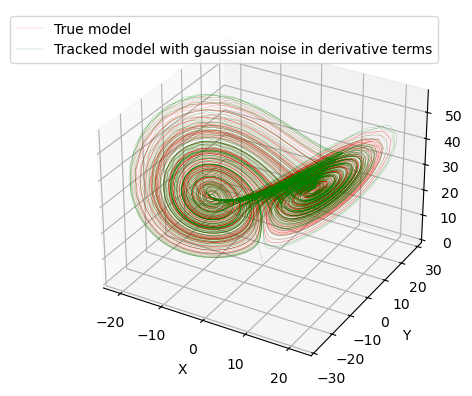

Average of distances calculated at each instant: 19.008302135347126
Average of minimum distances: 0.5002226795270602


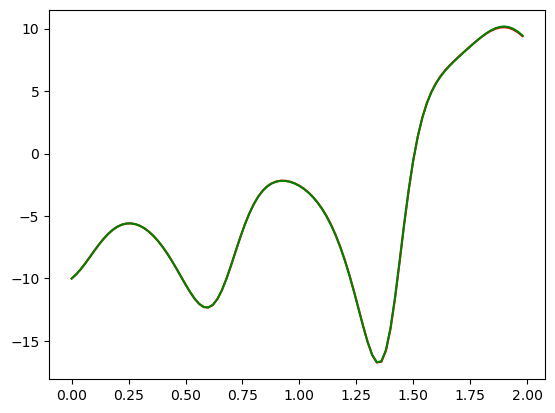

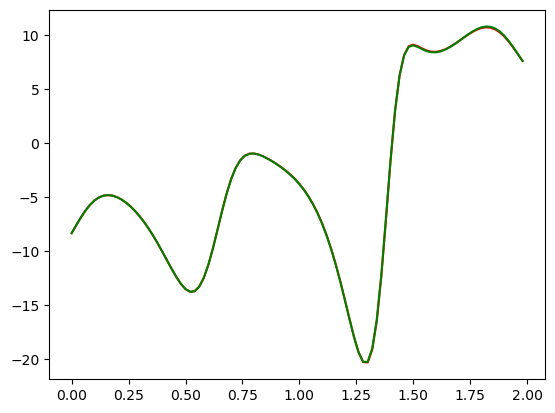

In [3]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 300                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.02
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
#A = sp.csr_matrix(A1)
A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    
    

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with gaussian noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], xpid[:100],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:100], ypure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], ypid[:100],  'g', label = 'Tracked model')
plt.show()

Without A

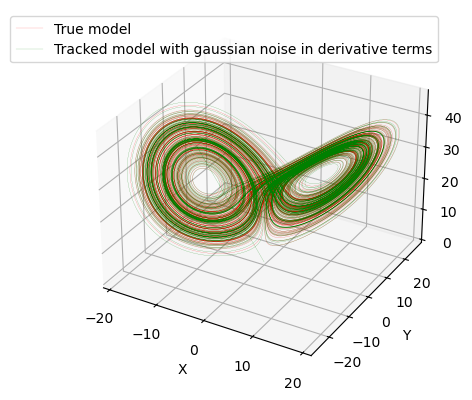

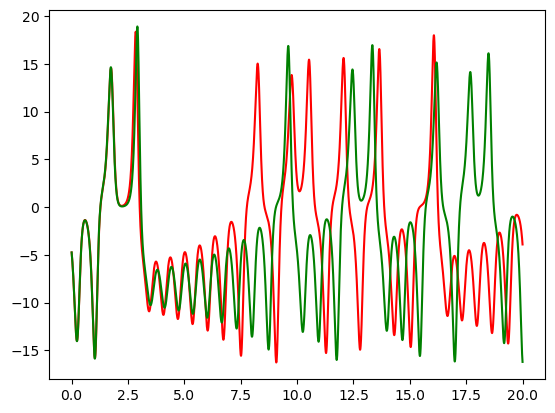

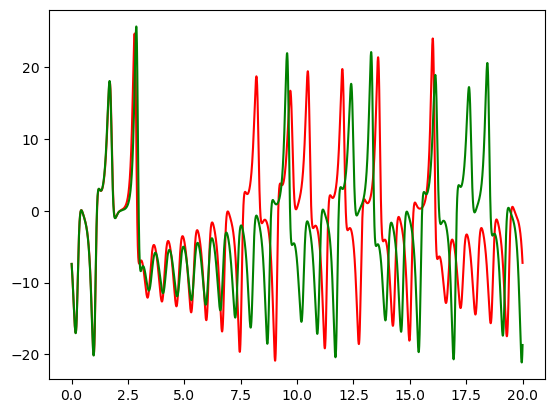

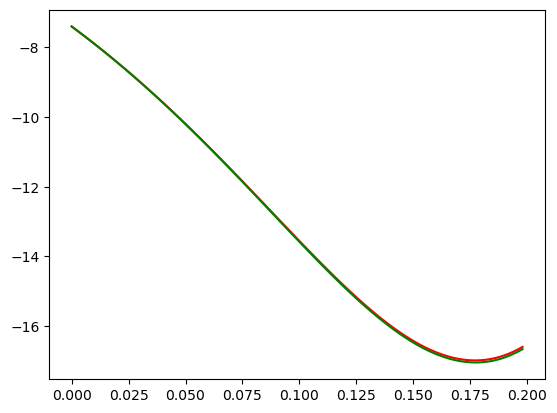

In [47]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.00001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
#A = sp.csr_matrix(A1)
A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    
    rpid = np.tanh(Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    
    

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with gaussian noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:10000], xpure[:10000], 'r', label = 'True model')
plt.plot(testingtimes[:10000], xpid[:10000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:10000], ypure[:10000], 'r', label = 'True model')
plt.plot(testingtimes[:10000], ypid[:10000],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[:100], ypure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], ypid[:100],  'g', label = 'Tracked model')
plt.show()

Can do a detailed simulation for multiple parameters - lamda, A and it's spectral radius, training time, dt value and see how long the forecasting is accurate. I can find the first instant when the prediction has some threshold error from the ideal model, and check plot it against when all these parameters are varied. Need to put the whole code into a function and call the function for all these parameter values. Make the function return the time at which the forecasting breaks. Use this to identify ideal parameters for forecasting. But it seems like the forecasting will eventually go to shit after some time. Need to see if I can predict the next step from the current sensor reading - actually make it a feedback controller. That should be the better PID controller.

With A:

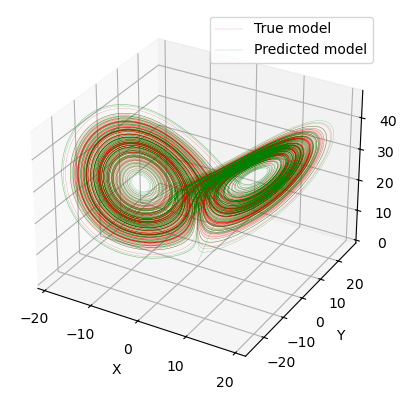

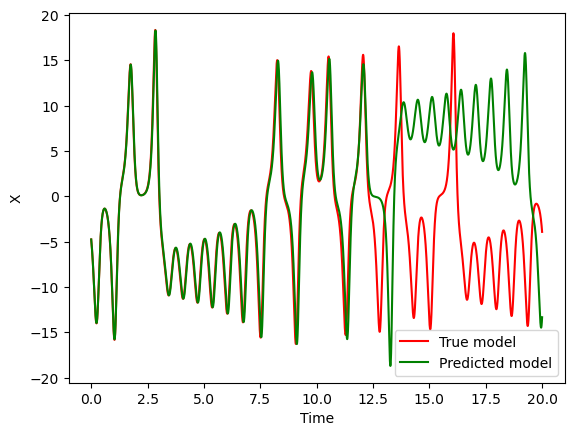

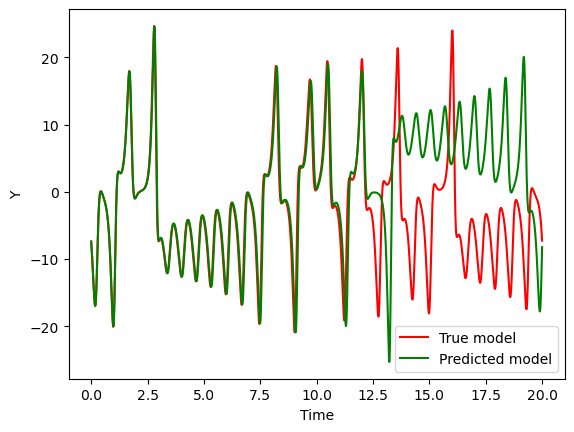

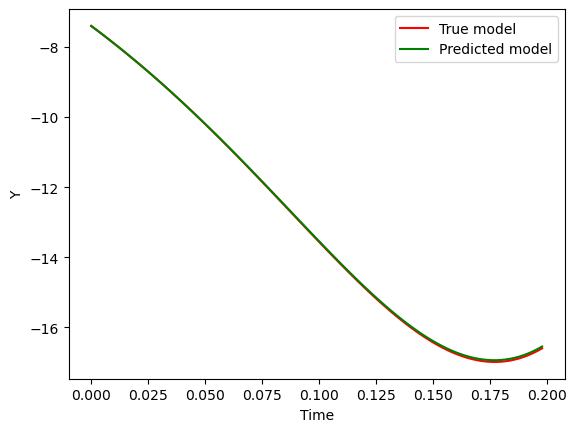

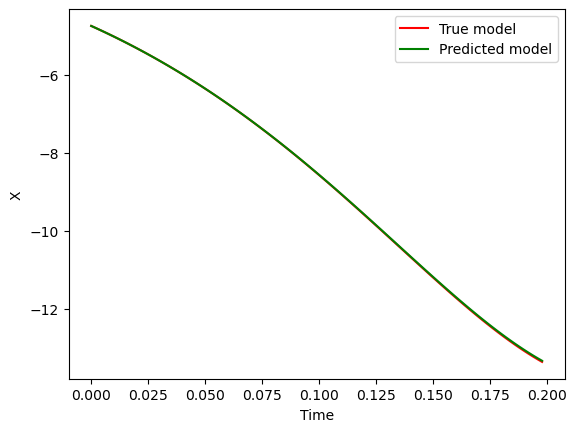

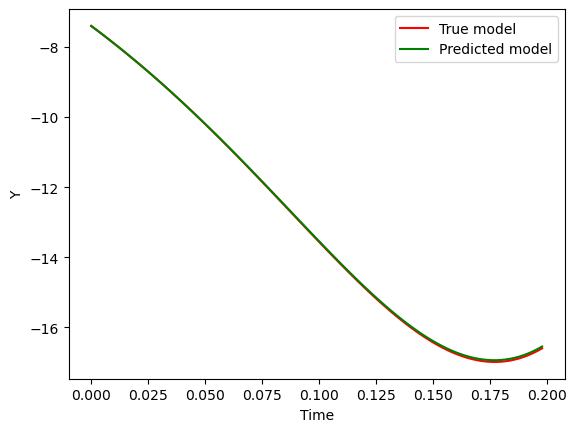

In [7]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.00001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)
#A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros(ntest)

## These two lines reset the states of everything. If they are not included
## the system will continue from the last state of the previous cell
## If they are included, the system will start from a new random state

#x, y, z = -7.45, -3.03, 0.01
#rpid = 0.5 - 1.0 * np.random.rand(n)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

# rpid = 0.5 - 1.0 * np.random.rand(n)

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    
    
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    
    

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
# A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
# B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
# avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
# print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:10000], xpure[:10000], 'r', label = 'True model')
plt.plot(testingtimes[:10000], xpid[:10000],  'g', label = 'Predicted model')
plt.xlabel('Time')
plt.ylabel('X')
plt.legend()
plt.show()


plt.figure()
plt.plot(testingtimes[:10000], ypure[:10000], 'r', label = 'True model')
plt.plot(testingtimes[:10000], ypid[:10000],  'g', label = 'Predicted model')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[:100], ypure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], ypid[:100],  'g', label = 'Predicted model')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.show()

plottimerange = np.arange(0, 100)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpid[plottimerange],  'g', label = 'Predicted model')
plt.xlabel('Time')
plt.ylabel('X')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypid[plottimerange],  'g', label = 'Predicted model')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()
plt.show()